In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau

# import time
# from timeout_decorator import timeout

from LoadBatch import *
from SensorClasses import *

verbose = False


In [2]:
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')
# logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')

In [3]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
### I should just have many options for ranges and choose between those
large_bins = (np.arange(0, 900,1),
              np.arange(0, 900,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(150, 450, 1))

bins2 = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
# sensors_list = read_pickle("sensors_list.pickle")  ### I still need the sensor_list for now
# dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

# logging.info(f"dictionary of the runs: \n{dict_of_runs}")
logging.info(f"dictionary of the batches: \n{dict_of_batches}")

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70", "noise", "width"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

## Charge plot

In [12]:
this_batch = 401
this_scope = 'S1'
DUTs = [1,2,3]

df = load_batch(this_batch, this_scope, branches=branches)


In [8]:
mins = [find_min_btw_peaks(df[f"pulseHeight_{i}"], bins='rice', plot=False) for i in DUTs]

In [6]:
# ### make it into an interactive plot???? mmm.. not really working
# ### I should probably add it to plot()

# xlim = (-10e3,0)

# fig, axes = plt.subplots(figsize=(8*len(DUTs),8), ncols=len(DUTs), dpi=150)#, sharey=True )
# for i,dut in enumerate(DUTs):

#     info = time_mask(df, dut, bins=10000, plot=False)[1]
#     left_base, right_base = info['left_base'], info['right_base']
    
#     pulse_cut = mins[i]
#     time_array = np.array(df[f'timeCFD50_{dut}']-df[f'timeCFD20_0'])
#     pulseheight_array = np.array(df[f'pulseHeight_{dut}'])
#     axes[i].plot(time_array, pulseheight_array, '.', markersize=0.8)
    
#     axes[i].set_xlim(xlim)
#     ylim = axes[i].get_ylim()
    
#     total = len(time_array)/100  ### so I get percentage directly
#     axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array<pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, -5), fontsize=16)
#     axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array<pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, -5), fontsize=16)
#     axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array<pulse_cut)])/total)+"%", ((right_base+left_base)/2, -5), fontsize=16)

#     axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array>pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, (pulse_cut+ylim[1])/2), fontsize=16)
#     axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array>pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, (pulse_cut+ylim[1])/2+20), fontsize=16)
#     axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array>pulse_cut)])/total)+"%", ((right_base+left_base)/2, (pulse_cut+ylim[1])/2+50), fontsize=16)

#     axes[i].axhline(pulse_cut,color='r', label="PulseHeight cut value: %.1f mV"%pulse_cut)
#     axes[i].axvline(left_base, color='g', alpha=.9, label="Time cut: %.0fps$<\Delta t<$ %.0fps"%(left_base, right_base))
#     axes[i].axvline(right_base, color='g', alpha=.9)
#     axes[i].set_xlabel(f"$\Delta t$ [ps] (DUT {dut} - MCP)", fontsize=16)
#     axes[i].set_ylabel(f"PulseHeight [mV]", fontsize=16)
#     axes[i].grid('-')
# #     axes[i].set_xlim(-7e3,-4e3)
#     axes[i].legend(fontsize=16, loc='upper center', framealpha=0)
#     axes[i].set_title(f"Sensor: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}", fontsize=16)
    
# for ax in axes:
#     ax.sharey(axes[0])

# fig.suptitle(f"PulseHeight vs $\Delta t$ \t Batch:{this_batch} {this_scope} ", fontsize=24)
# # fig.savefig(f"../various plots/pulseHeight_vs_deltat_{this_batch}_{this_scope}_{DUTs}.jpg") ### svg is way too big

### Plotting three different cuts (pulseHeight, geometric and time) and comparing them with each other
and now fitting with the charge too

[INFO] - 	 in 'time_mask()': Fit parameters [ 7190.32272684 -5485.40216075    86.41626505    77.25582711]
[INFO] - 	 in 'time_mask()': Fit parameters [ 5956.24525132 -5512.14735234    83.71788932    84.09735789]


Text(0.5, 0.98, 'Charge plot batch:301, S1, Ch2 \n comparison between different cuts')

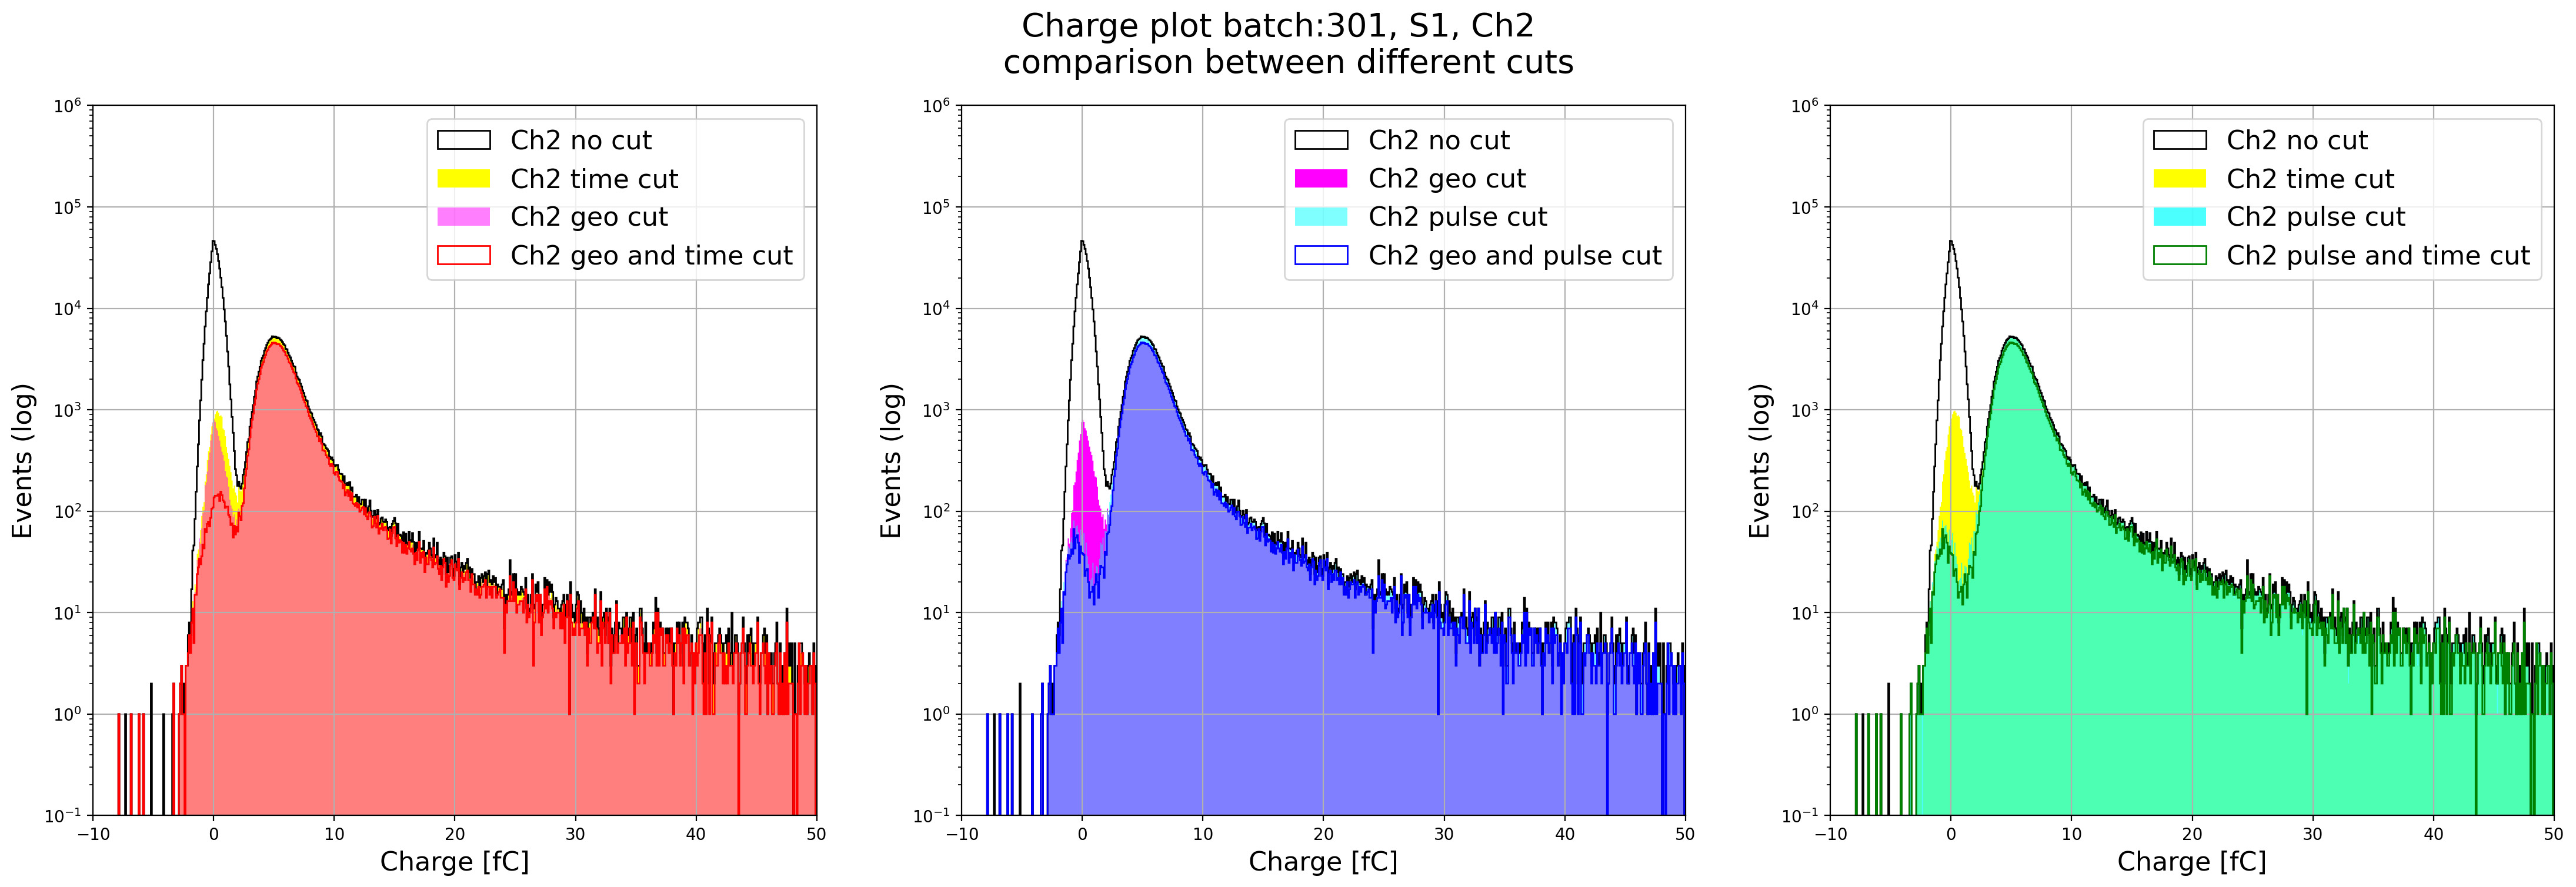

In [16]:
DO_FIT = False
### colors   0   1   2   3     4      5         6
colormap = ['k','r','g','b','cyan','yellow','magenta']
color_geo, color_pulse, color_time = 'magenta', 'cyan', 'yellow'

transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in DUTs]
time_cuts = [time_mask(df, dut, bins=5000, plot=False)[0] for dut in DUTs]
geo_cuts = [geometry_mask(df, bins=bins1, bins_find_min='rice', DUT_number=dut)[0] for dut in DUTs]
pulse_cuts = [df[f'pulseHeight_{dut}']>mins[dut-1] for dut in DUTs]
dut = 1

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3*9,8), dpi=200)
for i in range(3):
    hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}']/transimpedance[dut-1], bins='auto',
                                          color=colormap[0], label=f"Ch{dut+1} no cut",
                                          fig_ax=(fig,axes[i]))
bins_centers = (my_bins[1:]+my_bins[:-1])/2
bins_centers = bins_centers.astype(np.float64)
legend_text = []
### --------------------------------
hist_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_time, alpha=1, label=f"Ch{dut+1} time cut",
                                       fig_ax=(fig,axes[0]))

hist_geo_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_geo, alpha=0.5, label=f"Ch{dut+1} geo cut",
                                       fig_ax=(fig,axes[0]))

hist_geo_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],time_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[1], alpha=1, label=f"Ch{dut+1} geo and time cut",
                                       fig_ax=(fig,axes[0]))

if DO_FIT:
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_time_cut, p0=(10,1,1,np.max(hist_geo_time_cut)))
    axes[0].plot(bins_centers, pylandau.langau(bins_centers, *param),color='k', label="Landau*Gaussian fit")
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals

### --------------------------------
hist_geo_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_geo, alpha=1, label=f"Ch{dut+1} geo cut",
                                       fig_ax=(fig,axes[1]))

hist_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_pulse, alpha=0.5, label=f"Ch{dut+1} pulse cut",
                                       fig_ax=(fig,axes[1]))

hist_geo_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[3], alpha=1, label=f"Ch{dut+1} geo and pulse cut",
                                       fig_ax=(fig,axes[1]))
if DO_FIT:
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_pulse_cut, p0=(10,1,1,np.max(hist_geo_pulse_cut)))
    axes[1].plot(bins_centers, pylandau.langau(bins_centers, *param), color='k', label="Landau*Gaussian fit")
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals

### --------------------------------

hist_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_time, alpha=1, label=f"Ch{dut+1} time cut",
                                       fig_ax=(fig,axes[2]))

hist_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_pulse, alpha=.7, label=f"Ch{dut+1} pulse cut",
                                       fig_ax=(fig,axes[2]))

hist_pulse_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[2], alpha=1, label=f"Ch{dut+1} pulse and time cut",
                                       fig_ax=(fig,axes[2]))

if DO_FIT:
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_pulse_time_cut, p0=(10,1,1,np.max(hist_pulse_time_cut)))
    axes[2].plot(bins_centers, pylandau.langau(bins_centers, *param), color='k', label="Landau*Gaussian fit")

for i in range(3):
    axes[i].semilogy()
    axes[i].set_xlim(-10,50)
    axes[i].set_ylim(0.1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events (log)", fontsize=16)
    handles, labels = axes[i].get_legend_handles_labels()
    if DO_FIT: handles.append(mpatches.Patch(color='none', label=legend_text[i]))
    axes[i].legend(handles=handles, fontsize=16);
    
fig.suptitle(f"Charge plot batch:{this_batch}, {this_scope}, Ch{dut+1} \n comparison between different cuts", fontsize=20)
# fig.savefig(f"../various plots/Charge_plot_comparison_{this_batch}_{this_scope}_Ch{dut+1}.jpg")

In [9]:
dut = 2
charge_fit(df, dut=dut, mask=np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1]), transimpedance=transimpedance[dut-1], plot=False)

NameError: name 'geo_cuts' is not defined

### Now I really need to automatically calculate the charge

In [14]:
geo_cuts = [geometry_mask(df, DUT_number=dut, bins=bins1, bins_find_min='rice')[0] for dut in DUTs]
time_cuts = [time_mask(df, DUT_number=dut)[0] for dut in DUTs]

'S1'

/tmp/ipykernel_41557/857255984.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i].plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
/tmp/ipykernel_41557/857255984.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i].plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
/tmp/ipykernel_41557/857255984.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i].plot(bins_centers, 

Text(0.5, 1.05, 'Charge distribution and Landau*Gaussian fit')

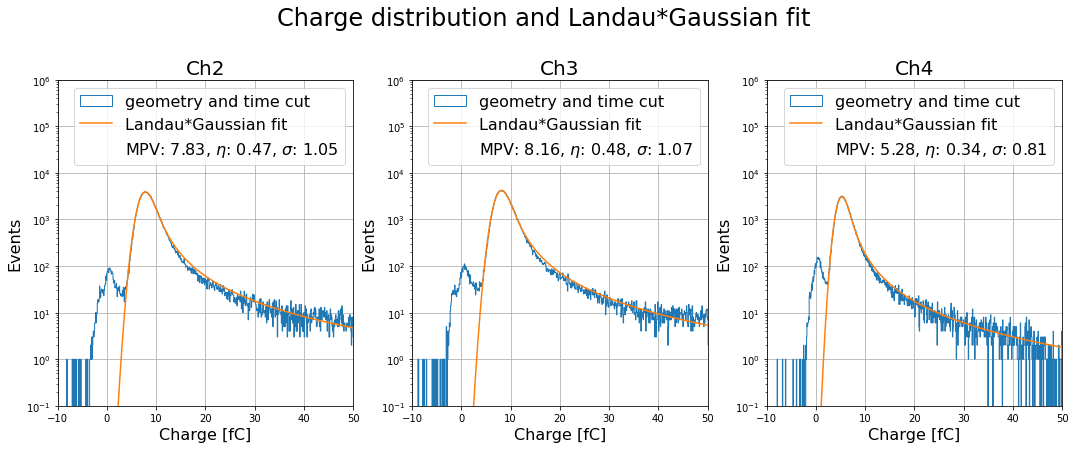

In [40]:
### probably I should add this to plot()

fig, axes = plt.subplots(figsize=(6*len(DUTs),6), ncols=len(DUTs))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')
for i,dut in enumerate(DUTs):
    transimpedance = dict_of_batches[this_batch].S[this_scope].get_sensor(f'Ch_{dut+1}').transimpedance
    hist_geo_time_cut,my_bins,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],time_cuts[dut-1])]/transimpedance), bins='auto',
                                           histtype='step', alpha=1, label=f"geometry and time cut",
                                           fig_ax=(fig,axes[i]))

    bins_centers = (my_bins[1:]+my_bins[:-1])/2
    bins_centers = bins_centers.astype(np.float64)

    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_time_cut, p0=(my_bins[np.argmax(hist_geo_time_cut)],1,1,np.max(hist_geo_time_cut)))

    axes[i].plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
    axes[i].semilogy()
    axes[i].set_xlim(-10, 50)
    axes[i].set_ylim(0.1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events", fontsize=16)
    axes[i].grid('--')
    axes[i].set_title(f'Ch{dut+1}',fontsize=20)
    legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
    handles, labels = axes[i].get_legend_handles_labels()
    handles.append(mpatches.Patch(color='none', label=legend_text))
    axes[i].legend(handles=handles, fontsize=16);
    
fig.suptitle(f"Charge distribution and Landau*Gaussian fit", fontsize=24, y=1.05)

# fig.savefig(f"../various plots/Charge_distribution_fit_Ch2_{this_batch}.svg",bbox_inches='tight')
